In [25]:
# ================================================================
# SECTION 1: Imports and configuration
# ================================================================

import os
import re
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import spacy

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

warnings.filterwarnings("ignore")

# Make sure these are downloaded once on your machine
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Load spaCy small English model (make sure you ran: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

plt.rcParams["figure.figsize"] = (10, 6)

# Root folder where all your txt files live (already extracted)
TXT_ROOT = "abcd_papers"  # change if needed


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elnaztoreihi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elnaztoreihi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elnaztoreihi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
# ================================================================
# SECTION 2: File loading and metadata extraction
# ================================================================

def get_all_txt_files(root):
    txt_files = []
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            if fname.lower().endswith(".txt"):
                txt_files.append(os.path.join(dirpath, fname))
    return sorted(txt_files)


def parse_year_and_doi_from_filename(path):
    """
    Expected pattern:
      Something-like-this-2023-10.1016_j.jaac.2024.10.01.txt
    We assume:
      - There is a 4 digit year (19xx or 20xx)
      - Everything after the year and hyphen is DOI with underscores
    """
    basename = os.path.basename(path)
    name = basename.replace(".txt", "")

    parts = name.split("-")

    # find year
    year = None
    for p in parts:
        if re.fullmatch(r"(19|20)\d{2}", p):
            year = int(p)
            break

    if year is None:
        raise ValueError(f"Could not find year in filename: {basename}")

    year_idx = parts.index(str(year))

    # DOI part is everything after the year
    doi_raw = "-".join(parts[year_idx + 1 :])
    doi = doi_raw.replace("_", "/")

    return year, doi


txt_files = get_all_txt_files(TXT_ROOT)
print(f"Found {len(txt_files)} txt files")

# Quick sanity check on a few
for path in txt_files[:5]:
    y, d = parse_year_and_doi_from_filename(path)
    print(os.path.basename(path), "->", y, d)


Found 1293 txt files
Acosta-Rodriguez-2024-10.31083_j.jin2312217.txt -> 2024 10.31083/j.jin2312217
Acosta-Rodriguez-2025-10.3174_ajnr.A8774.txt -> 2025 10.3174/ajnr.A8774
Adams-2024-10.1016_j.bpsc.2024.03.006.txt -> 2024 10.1016/j.bpsc.2024.03.006
Adams-2024-10.1016_j.dadr.2024.100271.txt -> 2024 10.1016/j.dadr.2024.100271
Adeli-2020-10.1016_j.neuroimage.2020.117293.txt -> 2020 10.1016/j.neuroimage.2020.117293


In [171]:
# ================================================================
# SECTION 3: Stopwords and text cleaning
# ================================================================

def create_custom_stopwords():
    stop_words = set(stopwords.words("english"))

    academic_stopwords = {
        "study", "studies", "research", "data", "analysis", "results", "methods",
        "findings", "paper", "article", "present", "used", "using", "use",
        "based", "also", "however", "may", "within", "across", "among",
        "et", "al", "etc", "ie", "eg", "figure", "table", "section",
        "abstract", "introduction", "discussion", "conclusion", "background",
        "participants", "participant", "sample", "samples", "examined", "measured",
        "associated", "association", "associations", "significant", "significantly",
        "year", "years", "time", "total", "number", "two", "three", "one",
        "first", "second", "third", "including", "included", "include",
        "reported", "report", "reports", "showed", "show", "shown",
        "found", "finding", "observed", "observation",
        "www", "http", "https", "doi", "pmid",
        "supplementary", "supplemental", "appendix", "supporting", "material",
        "author", "authors", "copyright", "permission",
        "acknowledgment", "acknowledgements", "correspondence",
        "department", "university", "institution", "journal",
        "online", "onlinelibrary", "library", "publisher", "publication",
        "vol", "issue", "page", "pages", "print", "preprint", "manuscript",
        "ref", "refs", "etable", "etable1", "efigure", "unitedstate",
        "medrxiv", "biorxiv", "preprint", "license", "rights", "reserved",
        "inaddition", "ing", "forexample", "childrenage", "yearfollow", "originalinvestigation", 
        "ameta", "reprint", "allrightsreserve", "insupplement", "supplement",
        "jamanetwork", "jamanetworkopen", "jamapediatric",
        "cid", "ion", "val", "andg", "min", "half", "count",
        "download", "user", "bear", "bed", "mind", "pubme", "int", "crossref",
        "ratio", "rat", "timepoint", "watch", "back", "day", "hour", "week",
        "indicator", "solution", "membership", "loading", "elevated",
            # ----- Publisher metadata / journal artifacts -----
    "theauthor", "authorcontribution", "supplementarytable", "plosone",
    "biologicalpsychiatry", "americanmedicalassociation",
    "adolescentbraincognitivedevelopment", "devcognneurosci",
    "plo", "losangele",  # broken "Los Angeles"
    "recruitingtheabcdsample",
    
    # ----- PDF extraction junk / broken strings -----
    "pubme", "cyberbullye", "wave",      # wave is tricky; extremely common ABCD artifact
    "yearsold", "mid", "gmv", "rois",    # MID is a task, but "mid" alone is noise
    "timepoint", "proportion", "probability",  # statistical boilerplate
    "assumption", "confidence", "equation",

    # ----- Highly generic time or measurement words -----
    "day", "hour", "week", "night", "visit",

    # ----- Generic statistical / model words -----
    "cluster", "subgroup", "membership", "solution",
    "indicator", "loading", "intercept", "slope",
    "monitoring", "inference",

    # ----- Too-general verbs/adjectives -----
    "persistent", "advanced", "accelerate", "accelerated",
    "familial", "severity", "developmental",  # too broad, non-topic-specific
    
    # ----- Vague noise words that add no semantic value -----
    "meet", "true", "friend", "team", "participation",
    "guideline", "recommendation", "movie", "mature",
    "internet", "television", "gaming",
    
    # ----- Broken substrings / common PDF fragments -----
    "putaman",   # misspelled putamen
    "gmv",       # appears as fragment rather than meaningful metric sometimes
    "smri",      # often appears as prefix rather than concept
    "int",       # leftover from "internalizing"
    "pvalue",    # common broken substring

     # Topic 1 artifacts
    "seetable", "inthesupplement", "ofth", "of the", "of_the",
    "frontiersinpsychiatry", "parentaleducation", "familyincome",
    "confidenceinterval", "incontrast", "abbreviation",

    # Topic 12 cleanup
    "plot", "property", "extend",

    # General PDF leftovers (rare but noisy)
    "midpoint",   # artifact from concussion papers

    "ofthe", "andu", "childdev", "yearsofage", "inthisstudy",
    "statisticalanalysis", "assuch",
    "theadolescentbraincognitivedevelopment",
    "srehsilbupdeillastifoenoronoitaicossalacigolohcyspnaciremaehtybdethgirypocsitnemucodsiht",
    "yldaorbdetanimessidebottonsidnaresulaudividniehtfoesulanosrepehtrofylelosdednetnisielcitrasiht",

    # demographic / generic terms
    "householdincome", "familyconflict",

    # Optional generic words
    "global", "regional",
    "close", "minute", "remote", "frequency",

     # --- Machine learning / statistical modeling terms ---
    "prediction", "predictive", "predictor", "training", "train", "accuracy",
    "graph", "matrix", "node", "map", "spatial", "similarity", "classification",
    "machine", "learning", "modeling", "model", "edge", "connectome",
    "parcellation", "parcel", "registration", "segmentation", "tractography",
    "metric", "feature", "algorithm", "fold", "deep", "cluster", "clustering",
    "selection", "variability", "estimation", "property", "threshold", "plot",
    "global", "regional",

    # --- PDF / GROBID artifact garbage ---
    "seefigure", "designconsiderationsandprocedure", "asystematicreview",
    "backtask", "ped", "ofthe", "andu", "childdev", "yearsofage",
    "inthisstudy", "statisticalanalysis", "assuch",
    "theadolescentbraincognitivedevelopment",
    "srehsilbupdeillastifoenoronoitaicossalacigolohcyspnaciremaehtybdethgirypocsitnemucodsiht",
    "yldaorbdetanimessidebottonsidnaresulaudividniehtfoesulanosrepehtrofylelosdednetnisielcitrasiht",

    # --- Demographic / supplemental noise ---
    "parentaleducation", "familyincome", "householdincome", "familyconflict",
    "inthesupplement", "incontrast", "abbreviation", "confidenceinterval",
    "peerreviewed",

    # --- Random non-developmental terms ---
     "service", "weekend",
    "daily", "minute", "frequency", "remote", "close",

    # --- Optional clinical instrument noise ---
    "ksad", "ksads", "cbcl", "childbehaviorchecklist", "sdsc",
    "attentionproblem", "workingmemory"

    # --- Generic filler words ---
    "propose", "proposed", "proposing"

     # Topic 0 cleanup
    "signal", "neutral",

    # Topic 4 MRI-artifact cleanup
    "scanner", "space", "compute", "modality", "slice",
    "achieve", "pair", "field", "voxel",

    # Topic 6 cleanup
    "pet", "device",

    # Topic 10 optional cleanup
    "opportunity",

    # Topic 13 cleanup
    "subscale",

    # Topic 14 cleanup
    "mode", "connection", "discovery",

    # Topic 15 cleanup
    "picture",

     # Topic 4 MRI technical noise
    "gradient", "whole", "acquire", "split", "mapping",
    "partition", "series", "application", "artifact", "pipeline",

    # Topic 8 statistical jargon
    "invariance", "rmsea", "transdiagnostic",

    # Topic 11 junk
    "monolingual", "offspre",

    # Topic 19 publication metadata
    "molecularpsychiatry", "creativecommon", "supervision",
    "theabcd", "correspondingauthor", "thisisamultisite",
    "garavanh", "caseybj", "somecollege", "newyork",

    # Topic 20 cleanup
    "loss", "signal"

    # Topic 1
    "developmentandpsychopathology", "hyperactivitydisorder", "neuropsychopharmacology",
    "bachelor", "socio", "path", "atotalof", "pdf", "rationaleanddescription",


    # Topic 3 broken fragments
    "sub", "con", "ence", "tive", "pro", "tional", "par", "sion",

    # Topic 5
    "siemen",

    # Topic 6 ML noise
    "multivariate", "architecture", "top", "wise", "organization",
    "representation", "input", "dynamic", "net",

    # Topic 17 optional
    "perceive"

    # Topic 10 miscellaneous junk
    "sport", "endorse", "schizophr", "persistence",

    # Topic 14 MRI technical artifacts
    "resolution", "layer", "evaluation", "distance",
    "vector", "noise", "length", "curve",

    # Publisher / metadata junk
    "raceandethnicity", "articleinformation", "management", "acceptedforpublication",
    "keypoint", "etis", "environmentalfactor", "obtainedfunde", "conceptanddesign",
    "equity", "supplementalcontent", "disclaimer", "ormaterialsupport",
    "andparticipant", "thatis", "afulllistofsupportersisavailableat", "caseyetal",
    "conceptualization", "supplementarymaterial", "imagingacquisitionacross",

    # Broken tokens / extraction artifacts
    "preprocesse", "assignment", "corticalthickness",
    "executivefunction", "externalizingproblem",

    # MRI pipeline noise
    "session", "frame", "boundary", "match", "filter", "distortion", "bold",

    # Methodological noise
    "challenge", "yield", "multi", "square", "ensure",
    "employ", "combination",

    # Generic / non-informative
     "phenotype", "front"

    # fMRI / pipeline artifacts
    "remove", "local", "code", "technique", "software",
    "experiment", "quantify", "repeat", "utilize", "stability",

    # Publisher junk / metadata
    "fpsyt", "phd", "raceandethnicity", "frontiersin",

    # Generic / low-value emotional or contextual terms
    "mvpa", "financial", "brief", "worry"

   # corrupted PDF artifacts
    "htlaeh", "dedaolnwod",

    # generic / non-thematic noise
    "continue", "front", "green", "nback",

    # fMRI / stats artifacts
    "permutation", "axis", "dimensional", "intrinsic", "remove",

    # statistical modeling words
    "analytic", "likelihood",

    ##recent
    # corrupted / nonsense tokens
    "schre", "eulavp",

    # metadata / publishing / boilerplate
    "areview", "openaccess", "competinginterest", "email",
    "availableat", "centile", "falsediscoveryrate",
    "developmentalcognitiveneuroscience",

    # method / pipeline jargon
    "assign", "fix", "block", "detect", "stable", "decision",
    "least", "choice",

    # machine-learning / modeling artifacts
    "auc", "kernel", "ieee", "elastic", "joint", "output"

    }

    # Common journal and platform names to drop
    journal_noise = {
        "jama", "lancet", "neuroimage", "nature", "science", "biol", "psych",
        "sciencedirect", "cellpress", "springer", "wiley", "elsevier",
        "oxford", "cambridge"
    }

    stop_words.update(academic_stopwords)
    stop_words.update(journal_noise)

    # Optional: ABCD boilerplate terms, comment this in if you want topics less about ABCD branding
    # abcd_stopwords = {"abcd", "adolescent", "brain", "cognitive", "development"}
    # stop_words.update(abcd_stopwords)

    return stop_words


STOPWORDS = create_custom_stopwords()


def clean_text(text):
    text = text.lower()

    # Remove URLs and emails
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)

    # Remove citation brackets [1], [2, 3]
    text = re.sub(r"\[[^\]]*\]", " ", text)

    # Remove common in-text citation patterns (Smith et al., 2020)
    text = re.sub(r"\([^)]+?\d{4}[^)]*\)", " ", text)

    # Remove non letter characters
    text = re.sub(r"[^a-z\s]", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [172]:
# ================================================================
# SECTION 4: Preprocess documents
# ================================================================

def preprocess_documents(txt_paths, min_word_length=3, min_tokens=50):
    docs_tokens = []
    doc_names = []
    years = []
    dois = []

    for idx, path in enumerate(txt_paths):
        if idx % 100 == 0:
            print(f"Processing {idx + 1}/{len(txt_paths)} documents")

        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue

        cleaned = clean_text(text)
        if not cleaned:
            continue

        spacy_doc = nlp(cleaned)

        tokens = [
            token.lemma_
            for token in spacy_doc
            if token.pos_ in {"NOUN", "ADJ", "VERB"}
            and token.lemma_ not in STOPWORDS
            and len(token.lemma_) >= min_word_length
            and not token.is_digit
        ]

        if len(tokens) < min_tokens:
            continue

        y, d = parse_year_and_doi_from_filename(path)

        docs_tokens.append(tokens)
        doc_names.append(os.path.basename(path))
        years.append(y)
        dois.append(d)

    meta_df = pd.DataFrame({
        "file_name": doc_names,
        "year": years,
        "doi": dois
    })

    print(f"Finished preprocessing. Kept {len(docs_tokens)} documents.")
    return docs_tokens, meta_df


processed_docs, meta_df = preprocess_documents(txt_files)
meta_df.head()


Processing 1/1293 documents
Processing 101/1293 documents
Processing 201/1293 documents
Processing 301/1293 documents
Processing 401/1293 documents
Processing 501/1293 documents
Processing 601/1293 documents
Processing 701/1293 documents
Processing 801/1293 documents
Processing 901/1293 documents
Processing 1001/1293 documents
Processing 1101/1293 documents
Processing 1201/1293 documents
Finished preprocessing. Kept 1293 documents.


,file_name,year,doi
0,Acosta-Rodriguez-2024-10.31083_j.jin2312217.txt,2024,10.31083/j.jin2312217
1,Acosta-Rodriguez-2025-10.3174_ajnr.A8774.txt,2025,10.3174/ajnr.A8774
2,Adams-2024-10.1016_j.bpsc.2024.03.006.txt,2024,10.1016/j.bpsc.2024.03.006
3,Adams-2024-10.1016_j.dadr.2024.100271.txt,2024,10.1016/j.dadr.2024.100271
4,Adeli-2020-10.1016_j.neuroimage.2020.117293.txt,2020,10.1016/j.neuroimage.2020.117293


In [173]:
# ================================================================
# SECTION 5: Dictionary, corpus, and coherence search
# ================================================================

def build_dictionary_and_corpus(processed_docs):
    dictionary = corpora.Dictionary(processed_docs)

    # Filter extremes: remove rare and overly common words
    dictionary.filter_extremes(
        no_below=10,    # min docs
        no_above=0.4,   # max fraction of docs
        keep_n=10000
    )

    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    print(f"Dictionary size: {len(dictionary)}")
    print(f"Corpus size: {len(corpus)} documents")
    return dictionary, corpus


dictionary, corpus = build_dictionary_and_corpus(processed_docs)


def compute_coherence_over_range(dictionary, corpus, texts, start=10, end=22, step=2):
    topic_nums = list(range(start, end + 1, step))
    coherences = []

    for k in topic_nums:
        print(f"Training LDA with {k} topics")
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=10,
            chunksize=100,
            alpha="auto"
        )

        cm = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )
        coh = cm.get_coherence()
        coherences.append(coh)
        print(f"  coherence (c_v) = {coh:.4f}")

    coh_df = pd.DataFrame({
        "num_topics": topic_nums,
        "coherence_c_v": coherences
    })
    return coh_df


coh_df = compute_coherence_over_range(dictionary, corpus, processed_docs, start=10, end=22, step=2)
coh_df


Dictionary size: 10000
Corpus size: 1293 documents
Training LDA with 10 topics
  coherence (c_v) = 0.5426
Training LDA with 12 topics
  coherence (c_v) = 0.5545
Training LDA with 14 topics
  coherence (c_v) = 0.5734
Training LDA with 16 topics
  coherence (c_v) = 0.6295
Training LDA with 18 topics
  coherence (c_v) = 0.6258
Training LDA with 20 topics
  coherence (c_v) = 0.6173
Training LDA with 22 topics
  coherence (c_v) = 0.5830


,num_topics,coherence_c_v
0,10,0.542585
1,12,0.554526
2,14,0.573386
3,16,0.629517
4,18,0.625764
5,20,0.617334
6,22,0.583022


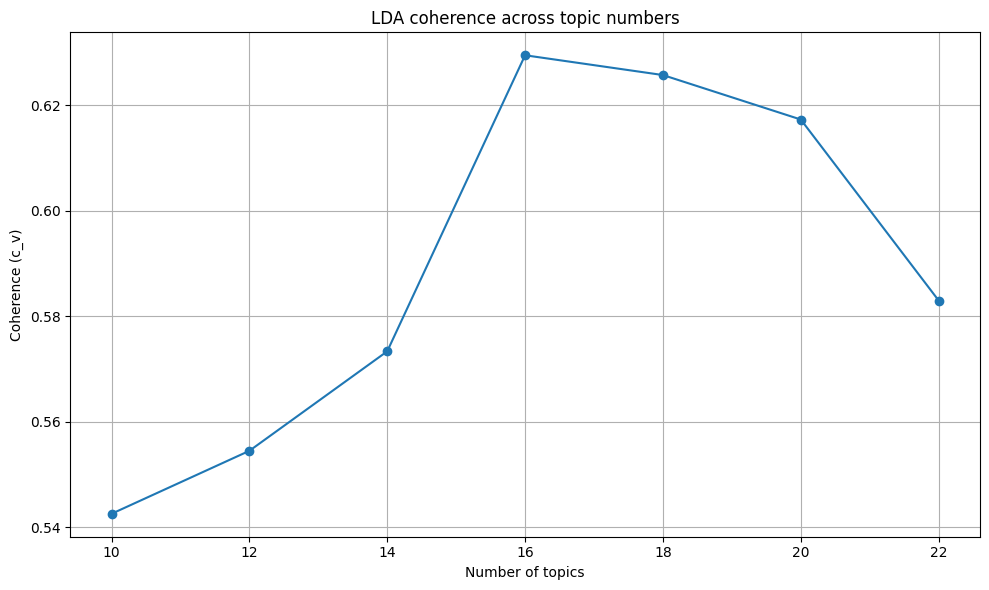

Best number of topics based on coherence: 16


In [174]:
# Save coherence values for Fig. 5
coh_df.to_csv("coherence_scores.csv", index=False)

plt.figure()
plt.plot(coh_df["num_topics"], coh_df["coherence_c_v"], marker="o")
plt.xlabel("Number of topics")
plt.ylabel("Coherence (c_v)")
plt.title("LDA coherence across topic numbers")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = coh_df.loc[coh_df["coherence_c_v"].idxmax(), "num_topics"]
print(f"Best number of topics based on coherence: {best_k}")


In [175]:
# ================================================================
# SECTION 6: Train final LDA model
# ================================================================

NUM_TOPICS = int(best_k)  # or set manually if you prefer, e.g. 16

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=20,
    chunksize=100,
    alpha="auto",
    per_word_topics=True
)

lda_model.save("abcd_lda_model_updated.model")
dictionary.save("abcd_dictionary_updated.dict")
print("Saved updated model and dictionary.")


Saved updated model and dictionary.


In [176]:
# ================================================================
# SECTION 7: Topic summary table (for Table 2 and word clouds)
# ================================================================

# Get dominant topic per document
dominant_topics = []
topic_counts = defaultdict(int)

for i, doc_bow in enumerate(corpus):
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    if not doc_topics:
        continue
    dom_topic, dom_prob = max(doc_topics, key=lambda x: x[1])
    dominant_topics.append(dom_topic)
    topic_counts[dom_topic] += 1

meta_df["dominant_topic"] = dominant_topics

# Build topic term table
rows = []
for t in range(NUM_TOPICS):
    terms = lda_model.show_topic(t, topn=30)
    num_docs = topic_counts.get(t, 0)
    for word, weight in terms:
        rows.append({
            "topic_id": t,
            "term": word,
            "weight": weight,
            "num_publications_in_topic": num_docs
        })

topics_table = pd.DataFrame(rows)
topics_table.to_csv("topics_table.csv", index=False)
topics_table.head()


,topic_id,term,weight,num_publications_in_topic
0,0,externalize,0.033639,134
1,0,ace,0.013664,134
2,0,dimension,0.012129,134
3,0,rule,0.010173,134
4,0,odd,0.007442,134


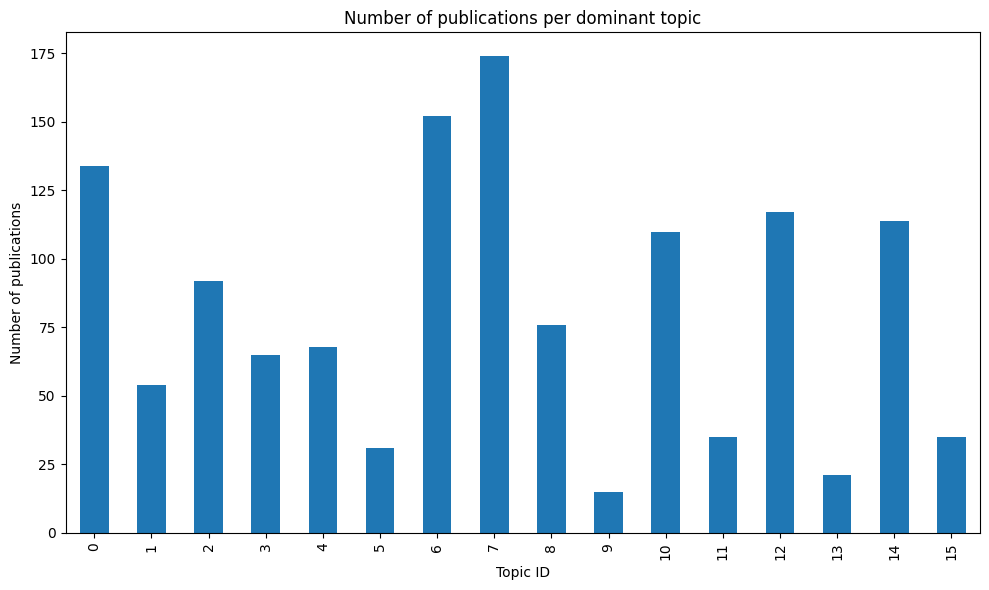

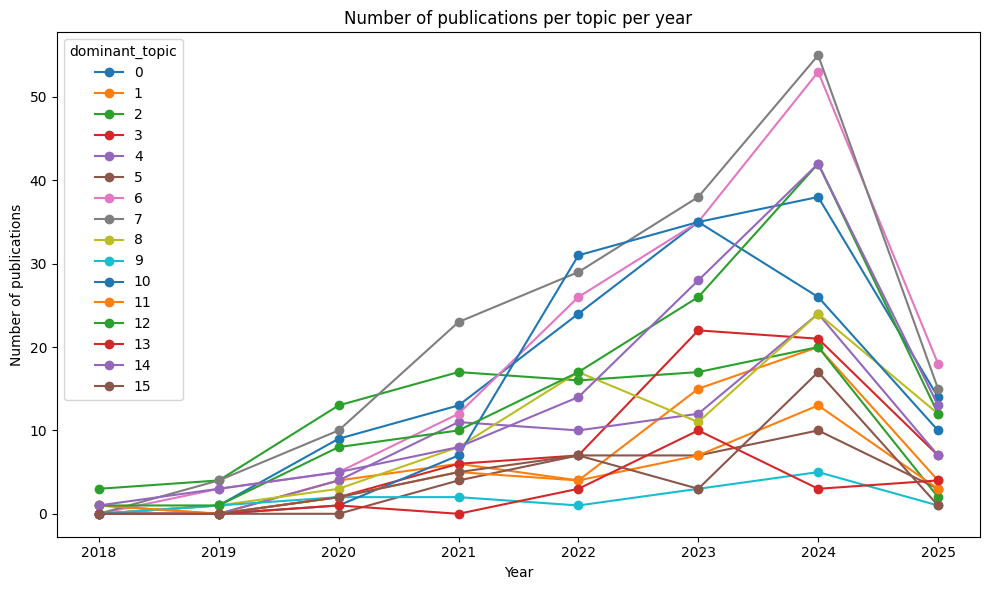

In [177]:
# ================================================================
# SECTION 8: Topic distribution overall and by year
# ================================================================

# Overall topic distribution
topic_counts_series = pd.Series(dominant_topics).value_counts().sort_index()
plt.figure()
topic_counts_series.plot(kind="bar")
plt.xlabel("Topic ID")
plt.ylabel("Number of publications")
plt.title("Number of publications per dominant topic")
plt.tight_layout()
plt.savefig("topic_distribution_updated.png", dpi=300)
plt.show()

# Attach probabilities too (for later if needed)
dominant_probs = []
for doc_bow in corpus:
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    dom_topic, dom_prob = max(doc_topics, key=lambda x: x[1])
    dominant_probs.append(dom_prob)

meta_df["dominant_topic_prob"] = dominant_probs

# Topic by year
topic_year_counts = meta_df.groupby(["year", "dominant_topic"]).size().reset_index(name="num_publications")

topic_year_pivot = topic_year_counts.pivot(
    index="year",
    columns="dominant_topic",
    values="num_publications"
).fillna(0).astype(int)

topic_year_pivot.to_csv("pubs_per_topic_per_year.csv")

topic_year_pivot.plot(kind="line", marker="o")
plt.xlabel("Year")
plt.ylabel("Number of publications")
plt.title("Number of publications per topic per year")
plt.tight_layout()
plt.savefig("topic_per_year_trends.png", dpi=300)
plt.show()


In [178]:
# ================================================================
# SECTION 9: File-level mapping (for Web of Science and Fig 6B)
# ================================================================

doc_topic_df = meta_df[["file_name", "year", "doi", "dominant_topic", "dominant_topic_prob"]].copy()
doc_topic_df.to_csv("doc_topic_assignments.csv", index=False)
doc_topic_df.head()


,file_name,year,doi,dominant_topic,dominant_topic_prob
0,Acosta-Rodriguez-2024-10.31083_j.jin2312217.txt,2024,10.31083/j.jin2312217,7,0.427499
1,Acosta-Rodriguez-2025-10.3174_ajnr.A8774.txt,2025,10.3174/ajnr.A8774,5,0.331243
2,Adams-2024-10.1016_j.bpsc.2024.03.006.txt,2024,10.1016/j.bpsc.2024.03.006,7,0.295070
3,Adams-2024-10.1016_j.dadr.2024.100271.txt,2024,10.1016/j.dadr.2024.100271,4,0.718741
4,Adeli-2020-10.1016_j.neuroimage.2020.117293.txt,2020,10.1016/j.neuroimage.2020.117293,6,0.307841


In [179]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Create interactive visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# 1) Show inside the notebook
pyLDAvis.display(vis)

# 2) Save as HTML to open in browser
pyLDAvis.save_html(vis, "topic_visualization_updated.html")
print("Saved to topic_visualization_updated.html")


Saved to topic_visualization_updated.html


In [180]:
from IPython.display import Markdown as md

for t in range(NUM_TOPICS):
    terms = lda_model.show_topic(t, topn=15)
    term_list = ", ".join([w for w, _ in terms])
    display(md(f"### Topic {t}\n{term_list}\n"))



### Topic 0
externalize, ace, dimension, rule, odd, depressive, depressed, trauma, diagnostic, creative, checklist, dsm, applicable, mood, govern


### Topic 1
cannabis, prenatal, pregnancy, alcohol, maternal, drug, caffeine, tobacco, hair, preterm, nicotine, mother, offspring, gestational, blood


### Topic 2
intelligence, language, executive, fluid, composite, read, neurocognitive, vocabulary, reading, flanker, speed, skill, crystallized, bilingual, sort


### Topic 3
eat, pain, obesity, bmi, binge, food, pollution, air, overweight, diet, chronic, gain, height, intake, percentile


### Topic 4
alcohol, suicide, impulsivity, suicidal, sip, attempt, urgency, seek, ideation, sensation, discount, delay, suicidality, drug, peer


### Topic 5
adhd, diffusion, tract, hyperactivity, autism, dmri, fiber, microstructure, tissue, medication, dti, tensor, stimulant, anisotropy, diffusivity


### Topic 6
fmri, motion, signal, propose, head, growth, replication, external, dimension, normative, medical, extract, residual, lifespan, generalizability


### Topic 7
thickness, subcortical, surface, frontal, gyrus, left, dmn, default, rsfc, parietal, gray, superior, prefrontal, cingulate, anterior


### Topic 8
discrimination, racial, ethnic, covid, pandemic, sexual, identity, minority, racism, latinx, orientation, american, cultural, disparity, perceive


### Topic 9
sport, depressive, injury, concussion, traumatic, head, tbi, mild, exercise, lifetime, density, involvement, bag, psychosocial, sustain


### Topic 10
gene, prs, twin, trait, genome, polygenic, variant, heritability, ancestry, gwa, pgs, snps, cell, expression, genotype


### Topic 11
reward, activation, trial, stop, inhibitory, inhibition, fmri, anticipation, irritability, delay, signal, sst, striatum, ssrt, stimulus


### Topic 12
neighborhood, adversity, caregiver, deprivation, peer, victimization, poverty, adverse, disadvantage, academic, violence, bully, perceive, protective, economic


### Topic 13
pubertal, girl, puberty, boy, timing, stage, maturation, hormone, pds, brainage, indirect, mediation, gap, reproductive, growth


### Topic 14
sleep, screen, duration, ple, medium, disturbance, video, psychotic, psychosis, game, sma, chronotype, spend, fitbit, distress


### Topic 15
profile, trait, emotion, latent, face, class, prosocial, regulation, externalize, stimulus, aggression, executive, threat, difficulty, callous
